# "MicroMouse" : Motor Selection

Below is an analysis used to determine a suitable motor for a robot designed for Dr. MacIver's lab. The intention of this robot is to act as a predeator and chase mice around a habit.
***

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv

## Design Contraints / Requirements

The robot will operate a hexagonal shapped habit with vinyl flooring that is ~3m in length across longest vertices and has various hexagonal shaped obstacles. Ideally, the robot will fit through the smallest potential opening, which given the obstacle spacing is a litte larger than 6cm. 

The mice move up to 1.7 m/s. If possible we would like the robot to move around 3 m/s, but at minimum it should be quicker than the mice, so at least 2 m/s linearly. The micromouse robots use cornering speed around 1 m/s and turn between 60 and 120 degrees.  

# THE CALCULATIONS AND GRAPHS BELOW ARE ACTUAL MICE DATA

Lets load the mice velocity data, so we can use it for simualtions later

In [2]:
# DOWNLOADS FOR MOUSE DATA
# % reset -f
import requests
# from google.colab import files
 
def cast(s):
    cf = True
    try:
        float(s)
    except ValueError:
        cf = False
    ci = True
    if cf:
        try:
            ci = int(s) == float(s)
        except ValueError:
            ci = False
    else:
        ci = False

    if ci:
         return int(s)
    if cf:
         return float(s)
    return s

def download (url, path = None):
    web_get = requests.get(url)
    if not path:
        path = url.split("/")[-1]
    with open(path, "wb") as f:
        f.write(web_get.content)
 


#download modules
download("https://github.com/germanespinosa/images/raw/master/map.py")
download("https://github.com/germanespinosa/images/raw/master/display.py")
download("https://github.com/germanespinosa/images/raw/master/world.py")
download("https://github.com/germanespinosa/images/raw/master/heat_map.py")
download("https://github.com/germanespinosa/images/raw/master/web_resources.py")
download("https://github.com/germanespinosa/images/raw/master/visibility.py")
download("https://github.com/germanespinosa/images/blob/master/data.json?raw=true", "data.json")
download("https://maciver-lab.github.io/plangame/maps/savanna.json")

#configure font
import matplotlib.font_manager as fm
 
download("https://github.com/germanespinosa/images/raw/master/Myriad%20Pro%20Regular.ttf","Myriad-Pro-Regular.ttf")
prop = fm.FontProperties(fname="Myriad-Pro-Regular.ttf")
fm.fontManager.addfont("Myriad-Pro-Regular.ttf")
font_name = prop.get_name()

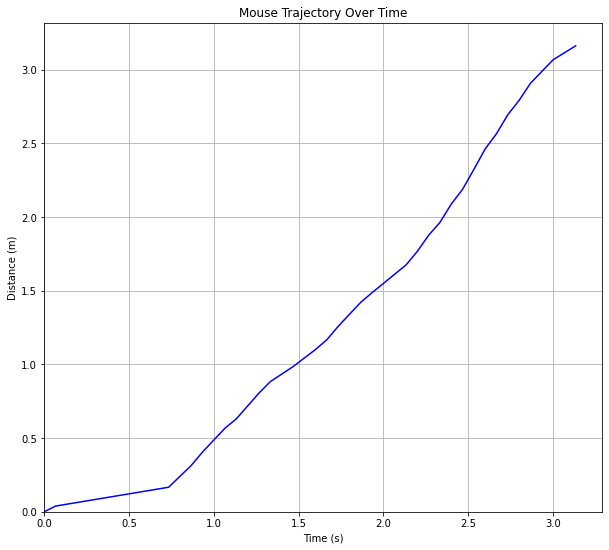

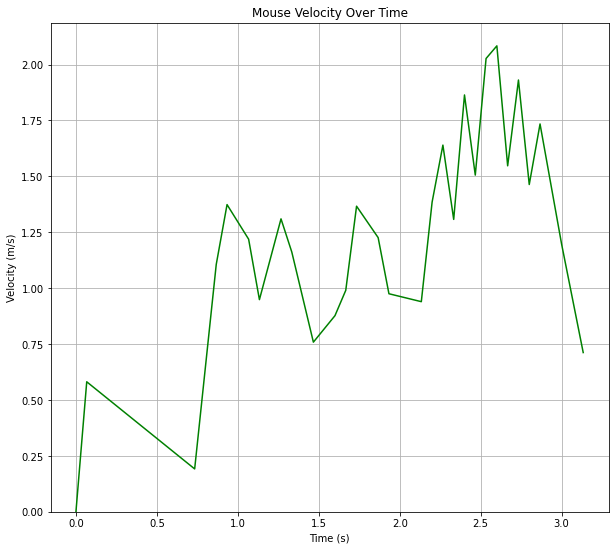

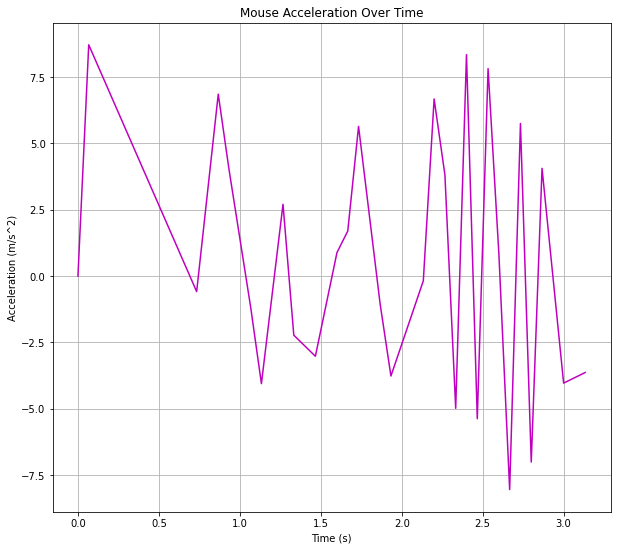

In [3]:
#RAW COORDINATE TEST
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
from world import World

world_name = "hexa_10_05"
file_name = "20210423_1520_FMM1_10_05_test.json"

w = World(world_name)
x = []
y = []
c = []
for cell in w.cells:
    x.append(cell["location"]["x"])
    y.append(cell["location"]["y"])
    c.append("white" if cell["occluded"] == 0 else "black")

y = [y*math.sqrt(3) for y in y]
# plt.style.use("dark_background")

# fig, ax = plt.subplots(1, 1, figsize=(10, 9))
# plt.scatter(x, y, c=c, alpha=1,  marker="h", s=825)

f = open(file_name)
data = json.load(f)
cmap=plt.get_cmap('jet')
color_index = np.linspace(0, 1,len(data))

# ax.set_title(name)
for j in (data['episodes']):
    count = 0
    x_coord=[]
    y_coord=[]
    distance = []
    distance_meter = []
    velocity = []
    accel = []
    time = []
    frame =[]
    first_coord = [j['trajectories'][0]['location']['x'],
                j['trajectories'][0]['location']['y']]
    first_frame = j['trajectories'][0]['frame']
    previous_coord = first_coord
    previous_frame = first_frame
    previous_dist = 0
    previous_dist_meter = 0
    prev_vel = 0

    fx = -1000
    fy = -1000
    i =1
    for y in (j['trajectories']):
        new_coord = [y['location']['x'],
                      y['location']['y']]

        time.append(y['frame']*(1/15))
        frame.append(y['frame'])

        if fx == -1000:
            fx = new_coord[0]
        if fy == -1000:
            fy = new_coord[1]
        fx = fx * (1-i) + new_coord[0] * i
        fy = fy * (1-i) + new_coord[1] * i
        x_coord.append(fx)
        y_coord.append(fy)
        step_dist = math.sqrt((new_coord[0]-previous_coord[0])**2 + (new_coord[1]-previous_coord[1])**2)
        step_dist_meter = 2.34/(220*20)*step_dist*220*20
        step_time = (y['frame']-previous_frame)*(1/15)

#         total_distance = previous_dist + step_dist
        total_distance_meter = previous_dist_meter + step_dist_meter
#         distance.append(total_distance)
        distance_meter.append(total_distance_meter)
        if step_time == 0:
            velocity.append(0)
        else:
            vel = step_dist_meter/step_time
            velocity.append(vel) 
        count = count + 1;
        previous_frame = y['frame']
        previous_coord = new_coord
#         previous_dist = total_distance
        previous_dist_meter = total_distance_meter
        
y_coord_hex = [y*200*20-(200*20)/2 for y in y_coord]
x_coord_hex = [(1-x)*220*20-(220*20)/2 for x in x_coord]
# print(velocity)

max_velocity = max(velocity)
max_index = velocity.index(max_velocity) 

#PLOT VELOCITIES OVER TIME
# fig2, ax0 = plt.subplots(figsize=(10, 9))

v2=[]
# i = (.1) # Filter value, this is used to average the velocities
i = 1 # With a filter of one, we get the actual values, not averaged
nv = 0
for v in velocity:
    nv = nv * (1-i) + v * i
    v2.append (nv)
    
seconds = []
for f in frame:
    sec = (f - 66)/15
    seconds.append(sec)

accel = []
vel_len = len(v2)
accel.append(0)
for k in range(0, vel_len-1):
    vk = v2[k]
    vk1 = v2[k+1]
    t1 = seconds[k]
    t2 = seconds[k+1]
    dT = t2 - t1
    dv = vk1 - vk
    a = dv / dT
    accel.append(a)
    
#     if a > 0:
#         accel.append(a)
#     else:
#         accel.append(0)
    
    
fig10, ax10 = plt.subplots(figsize=(10, 9))
ax10.set_ylabel('Distance (m)')
ax10.set_xlabel('Time (s)')
ax10.plot(seconds,distance_meter, "-b")
ax10.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
ax10.set_ylim(bottom= 0)
ax10.set_xlim(left= 0)
ax10.set_title("Mouse Trajectory Over Time")

fig0, ax0 = plt.subplots(figsize=(10, 9))
ax0.plot(seconds,v2, "-g")
ax0.set_ylabel('Velocity (m/s)')
ax0.set_xlabel('Time (s)')
ax0.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
ax0.set_ylim(bottom= 0)
ax0.set_title("Mouse Velocity Over Time")

fig100, ax100 = plt.subplots(figsize=(10, 9))
ax100.plot(seconds,accel, "-m")
ax100.set_ylabel('Acceleration (m/s^2)')
ax100.set_xlabel('Time (s)')
ax100.grid(b=None, which='both', axis='both', drawstyle = "steps-mid")
# ax100.set_ylim(bottom= 0)
ax100.set_title("Mouse Acceleration Over Time")

plt.show()

The mouse velocity vs time graph above just shows instantaneous velocities, so it doesn't mean that the mice reach 2m/s in 2.5 seconds, just that at 2.5 seconds the mouse happened to be moving that fast. So use this graph to get a general idea of the velocity ranges the mice move at. 

## Electrical motor specs

In order to derive the equations that govern a motor's behavior,  we first have to look at the electrical specs. The electrical power is going to be out input power after all, and the output power will be the mechanical power. 

Simply put, the input electrical power is...
 
$P_e = IV$

*Where I is current and V is Votlage*

However, this Input Power has to account for the Mechanical Output Power ($\tau\omega$) as well as power lost through heat dissipation and such. Therefore...

$IV = (\tau_{out} G)(\frac{\omega_{out}}{G}) + {I}^2 R + LI \frac{dI}{dt}$

*Where $G$ is the gear reduction*

Dividing by $I$ we can get an equation for the Voltage:

$V = \frac{\tau_{out}G}{I} (\frac{\omega_{out}}{G}) + IR + L \frac{dI}{dt}$


$\frac{\tau}{I}$ is a constant value, given Lorentz force law. This constant is called the torque constant $k_t$

$k_t = \frac{\tau}{I}$

$k_t G = \frac{\tau_{out}G}{I}$

$\tau_{out} = \frac{k_t I}{G}$

Rewrite the Voltage equation to incorparate the torque constant...

$V = k_t G \frac{\omega_{out}}{G} + IR + L \frac{dI}{dt}$

Going back to the Speed-Torque curve, we can assume that at a constant speed and constant torque the Voltage equation is reduced to...

$V = k_t G \frac{\omega_{out}}{G} + IR $

Solving for $\omega$ ...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Here, we can calculate the no load speed and stall torque given the electrical specs of the motor

$\omega_0 = \frac{V}{k_t}$

$\tau_s = \frac{k_t V}{R}$

## "RACE" SIMULATIONS

Considering that the motors have variable acceleration and velocities, perhaps the best place to start comparing motors is by simulaitng a "race" with various motors. These simulaitons only take into account motor parameters such as the torque constant $k_t$, voltage $V$, a motor's resistance $R$ and so on, parameters which we used in the governing equations above.  


Given the electrical input power equations above, we solved for $\omega$ given a motor's torque constant, voltage and resistance...

$\omega = \frac{1}{k_t} V - \frac{R}{{k_t}^2} \tau$

Now lets rearrange this equation to solve for torque:

$\omega - \frac{1}{k_t} V = - \frac{R}{{k_t}^2} \tau$

$\frac{R}{{k_t}^2} \tau = \frac{1}{k_t} V - \omega$

$R \tau = V k_t - \omega {k_t}^2$

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

Assuming a 100% effiecent motor, we can use these mechanical eqautions...

$F = ma$

$\tau = Fr = mar$

$v = \omega r$

$\omega = \frac{v}{r}$


Sub the appropriate equations into $\tau$ and $\omega$...

$\tau = \frac{V k_t - \omega {k_t}^2}{R} = \frac{k_t(V - \omega k_t)}{R}$

$mar = \frac{V k_t - \frac{v}{r} {k_t}^2}{R} = \frac{V k_t}{R} - \frac{v {k_t}^2}{Rr}$

$a = \frac{V k_t}{Rmr} - \frac{v {k_t}^2}{Rm{r}^2}$

$0 = a + \frac{v {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} $


Now that we've elimated torque and radial velocity from our equation, we have a function that is governed by two non-constant vairbles, acceleration $a$ and linear velocity $v$. Fortunately, both these varibales can be represented by 2nd and 1st order differentials of displacement over time (respectively). Now lets represent our funciton as only dependent on displacement over time....

$\frac{{d}^2 x}{d{t}^2} + \frac{\frac{dx}{dt} {k_t}^2}{Rm{r}^2} - \frac{V k_t}{Rmr} = 0$


Eliminate the constant value so we can solve for a solution:

$\frac{{d}^2 x}{d{t}^2} + \frac{{k_t}^2 \frac{dx}{dt}}{Rm{r}^2} = 0$


Assume the solution will be porpoertional to ${e}^{\lambda t}$ and sub $x(t)= {e}^{\lambda t}$ into the diff eq:

$\frac{{d}^2}{d{t}^2} {e}^{\lambda t} + \frac{{k_t}^2 \frac{d}{dt} {e}^{\lambda t}}{Rm{r}^2} = 0$

${\lambda}^2 {e}^{\lambda t} + \frac{{k_t}^2 \lambda {e}^{\lambda t}}{Rm{r}^2} = 0$

$({\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2}) {e}^{\lambda t} = 0$


Since ${e}^{\lambda t}$ CANNOT equal 0...

${\lambda}^2 + \frac{{k_t}^2 \lambda}{Rm{r}^2} = 0$

$\frac{\lambda ({k_t}^2 + \lambda Rm{r}^2)}{Rm{r}^2} = 0$


Solving for $\lambda$....

$\lambda = 0$

and

$\lambda = - \frac{{k_t}^2}{Rm{r}^2}$


For complementary solutions a root of $\lambda = 0$ gives $x_1(t) = c_1$

Also a root $\lambda = - \frac{{k_t}^2}{Rm{r}^2}$ gives $x_2(t) = c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$

Therefore the general solution is 

$x(t) = x_1 (t) + x_2 (t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}}$


Great! Now determine the particular solution by the method of undetermined coefficients where $x_p(t) = a_1 t$:

$\frac{dx_p(t)}{dt} = \frac{d}{dt}(a_1 t) = a_1$

$\frac{{d}^2 x_p(t)}{d{t}^2} = \frac{{d}^2}{d{t}^2} (a_1 t) = 0$

$\frac{{d}^2 x_p (t)}{d{t}^2} + \frac{{k_t}^2 \frac{d x_p (t)}{dt}}{Rm{r}^2} = \frac{k_t V}{R m r}$

$\frac{{k}^2 a_1}{Rm{r}^2} = \frac{k_t V}{Rmr}$

$a_1 = \frac{rV}{k_t}$

$x_p(t) = \frac{rVt}{k_t}$


Making the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$


Now lets solve with our givens $x(0) = 0$ and $\frac{dx}{dt}(0) = 0$. For t = 0 and x(0) = 0...

$c_1 + c_2 = 0$


Taking the derivative of our general solution we get:

$\frac{dx(t)}{dt} = \frac{rV}{k} - \frac{{k_t}^2 c_2 e^{-\frac{{k_t}^2 t}{Rm{r}^2}}}{Rm{r}^2}$


Subbing in $\frac{dx}{dt}(0) = 0$ for t = 0...

$\frac{rV}{k} - \frac{{k}^2 c_2}{Rm{r}^2} = 0$

$c_2 = \frac{Vm {r}^3 R}{{k}^3}$


Which means...

$c_1 = - \frac{Vm {r}^3 R}{{k}^3}$


Plugging the constants into the general solution:

$x(t) = c_1 + c_2 {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = - \frac{V Rm {r}^3}{{k}^3} + \frac{VRm {r}^3}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{rVt}{k_t}$

$x(t) = rV(- \frac{Rm {r}^2}{{k}^3} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} + \frac{t}{k_t})$

$x(t) = rV( \frac{t}{k_t} + \frac{Rm {r}^2}{{k}^3} {e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - \frac{Rm {r}^2}{{k}^3})$

$x(t) = \frac{rV( {k_t}^2 t + Rm{r}^2 ({e}^{-\frac{{k_t}^2 t}{Rm{r}^2}} - 1))}{{k_t}^3}$

# DOES THIS MAKE SENSE BELOW? HOW DO I INCORPORATE EFFECIENCY?!

We now have an equation for displacement over time, which, aside from the motor specs, is only dependent on wheel radius and time. But there are two more elements that have to be taken into consideration: gear reductions and motor efficieny. Luckily, the only varible influcened by a gear reduction and motor efficieny is $k_t$. This is because...

$k_t = \frac{\tau}{I}$

And if you multiply the torque by the gear reduction $G$ then the torque constant $k_t$ must be proportionately scaled. 

$k_t G = \frac{\tau_{out}G}{I}$

Given the equation below for efficiency $\eta$, how can I incorporate that into my simulation equation?

$\eta = \frac{\tau_{out} \omega}{IV} = \frac{k_t \omega}{V}$

<!-- $k_t G \eta = \frac{\tau_{out}G \eta}{I}$   **Is this correct?** -->

Therefore our final equation that we will be simulating is (WITHOUT EFFICIENCY)...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

<!-- $x(t) = \frac{rV( {(k_t G \eta)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G \eta)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G \eta)}^3}$ -->

## Robot Velocity, take derivative of x(t) equation. 

Given the displacement vs time equation from before...

$x(t) = \frac{rV( {(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))}{{(k_t G)}^3}$

Take the derivative of that equation to find the realtionship of velocity vs time. Lets start by rearranging it a bit.

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 ({e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - 1))$

$x(t) = \frac{rV}{{(k_t G)}^3}({(k_t G)}^2 t + Rm{r}^2 {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}} - Rm{r}^2)$

Now lets take the derivative with respect to $t$...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 + Rm{r}^2 \frac{{(-k_t G)}^2}{Rm{r}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x'(t) = \frac{rV}{(k_t G)} (1 - {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

## Robot Acceleration, take derivative of x'(t) equation. 

Given the velocity vs time equation from before...

$x'(t) = \frac{rV}{{(k_t G)}^3} ({(k_t G)}^2 -{{(k_t G)}^2} {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

Take the derivative of that equation to find the realtionship of accleration vs time.

$x''(t) = \frac{rV}{{(k_t G)}^3} (-{{(k_t G)}^2} \frac{{-(k_t G)}^2}{Rm{r}^2}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x''(t) = \frac{rV}{{(k_t G)}^3} (\frac{{(k_t G)}^4}{Rm{r}^2}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}})$

$x''(t) = \frac{V k_t G }{Rmr}  {e}^{-\frac{{(k_t G)}^2 t}{Rm{r}^2}}$

Now that we have our simualtion equations, its time t upload the motor information and simualte!

In [4]:
def read_csv(filename):
    motor_name = [] 
    nominal_V = []
    nominal_A = [] 
    single_motor_weight = [] 
    motor_no_load_RPM = [] 
    motor_max_t = [] 
    motor_stall_t = [] 
    motor_R = [] 
    motor_kt = [] 
    motor_eff = []
    motor_diam = []
    with open(filename) as f:
        # open the csv file
        reader = csv.reader(f)
        for row in reader:
            # read the rows 1 one by one
            motor_name.append(str(row[0]))
            nominal_V.append(float(row[1]))
            nominal_A.append(float(row[2]))
            single_motor_weight.append(float(row[3]))
            motor_no_load_RPM.append(float(row[4]))
            motor_max_t.append(float(row[5]))
            motor_stall_t.append(float(row[6]))
            motor_R.append(float(row[7]))
            motor_kt.append(float(row[8]))
            motor_eff.append(float(row[9]))
            motor_diam.append(float(row[10]))
         
    return motor_name, nominal_V, nominal_A, single_motor_weight, motor_no_load_RPM, motor_max_t, motor_stall_t, motor_R, motor_kt, motor_eff, motor_diam
    

In [5]:
filename_15W = "1.5W_motors_v2.csv"
motor_power_15W = 1.5
all_motor_name_15W, all_nominal_V_15W, all_nominal_A_15W, all_single_motor_weight_15W, all_motor_no_load_RPM_15W, all_motor_max_t_15W, all_motor_stall_t_15W, all_motor_R_15W, all_motor_kt_15W, all_motor_eff_15W, all_motor_diam_15W = read_csv(filename_15W)

filename_2W = "2W_motors_v2.csv"
motor_power_2W = 2
all_motor_name_2W, all_nominal_V_2W, all_nominal_A_2W, all_single_motor_weight_2W, all_motor_no_load_RPM_2W, all_motor_max_t_2W, all_motor_stall_t_2W, all_motor_R_2W, all_motor_kt_2W, all_motor_eff_2W, all_motor_diam_2W = read_csv(filename_2W)

filename_25W = "2.5W_motors_v2.csv"
motor_power_25W = 2.5
all_motor_name_25W, all_nominal_V_25W, all_nominal_A_25W, all_single_motor_weight_25W, all_motor_no_load_RPM_25W, all_motor_max_t_25W, all_motor_stall_t_25W, all_motor_R_25W, all_motor_kt_25W, all_motor_eff_25W, all_motor_diam_25W = read_csv(filename_25W)

print(f"1.5W Motors: {all_motor_name_15W}\n")
print(f"2W Motors: {all_motor_name_2W}\n")
print(f"2.5W Motors: {all_motor_name_25W}\n")

1.5W Motors: ['Maxon: ECX SPEED 6M ', 'Maxon: RE 10 (118396)', 'Maxon: RE 10 ( 118397)', 'Maxon: RE 10 (256101)', 'Maxon: RE 10 (256102)', 'Maxon: DCX 10L', 'Maxon: RE13 (118528) (4 diff?)', 'Maxon: RE13 (118529) (4 diff?)', 'Maxon: EC 14 (339251)', 'Maxon: A-max 19 (110094)', 'Maxon: A-max 19 (110095)']

2W Motors: ['Maxon: SPEED 6 M ', 'Maxon: SPEED 8 M', 'Maxon: RE13 (118500)', 'Maxon: RE13 (118501)', 'Maxon: RE 16 (320175)', 'Maxon: A-max 16 (110073) (6 options?)', 'Maxon: DC-max 16 (brushed)']

2.5W Motors: ['Maxon: DCX 12L ', 'Maxon: RE 13 ', 'Maxon: RE 13 ', 'Maxon: DCX 16S ', 'Maxon:  A-max 19 ', 'Maxon:  A-max 19 ']



In [6]:
tile_len = 0.1
time = seconds

def disp_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    disp = []
    
    ktGn = (kt / 1000) * G
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2t = (math.pow(ktGn, 2)) * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        x_t = (rV * (ktGn2t + (Rmr2 * (expon - 1)))) / math.pow(ktGn, 3)
        disp.append(x_t)
        
    return disp

def vel_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    vel = []
    
    ktGn = (kt / 1000) * G 
    rV = wheel_rad * input_V
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2 = (math.pow(ktGn, 2))
        ktGn2t = ktGn2  * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        v_t = (rV / (math.pow(ktGn, 3))) * (ktGn2 - (ktGn2 * expon))
        
        if v_t < 3.0:
            vel.append(v_t)
        else:
            vel.append(3.0)
        
    return vel

def accel_simulation(m_kg, kt, G, input_V, motor_R, wheel_rad, eta):
    # m_kg: total mass in kg, kt in mNm/A, input V in Volts, motor R in ohms,  wheel_rad in m
    
    accel = []

    ktGn = (kt / 1000) * G 
    ktGn2 = (math.pow(ktGn, 2))
    Rmr2 = motor_R * m_kg * math.pow(wheel_rad, 2)
    
    for t in time:
        ktGn2t = ktGn2  * t
        expon = math.exp( -ktGn2t / Rmr2)
    
        a_t = (((kt / 1000) * input_V *G) / ( motor_R * m_kg * wheel_rad )) * expon
        accel.append(a_t)
        
    return accel


def input_power(m_accel, wheel_r, lin_vel, eta, mass, I, R):
    
    P_input = []
    
    for i in range(0,len(time)):
#         torque = abs(mass * m_accel[i] * wheel_r)
        torque = mass * m_accel[i] * wheel_r
        omega = lin_vel[i] / wheel_r
        
#         print(f"Torque requirements are {round(torque*1000, 1)}mNm")
        
#         print(f"""For mass of {mass}kg, wheel radius of {wheel_r}m, linear vel of {lin_vel[i]}, 
#               acceleration of {m_accel[i]} m/s^2, effeciieny of {eta}, the torque is {torque}\n""")

        Pm = torque * omega
        Pi = (Pm / eta)
#         Pi = (Pm / eta) + (I*I*R)
#         P_input.append(Pi)
        P_input.append(abs(Pi))
    
    return P_input

Current for 1.5W is 0.6880733944954128 and resistance is 8.72 
 therefore I2R is 4.128440366972478


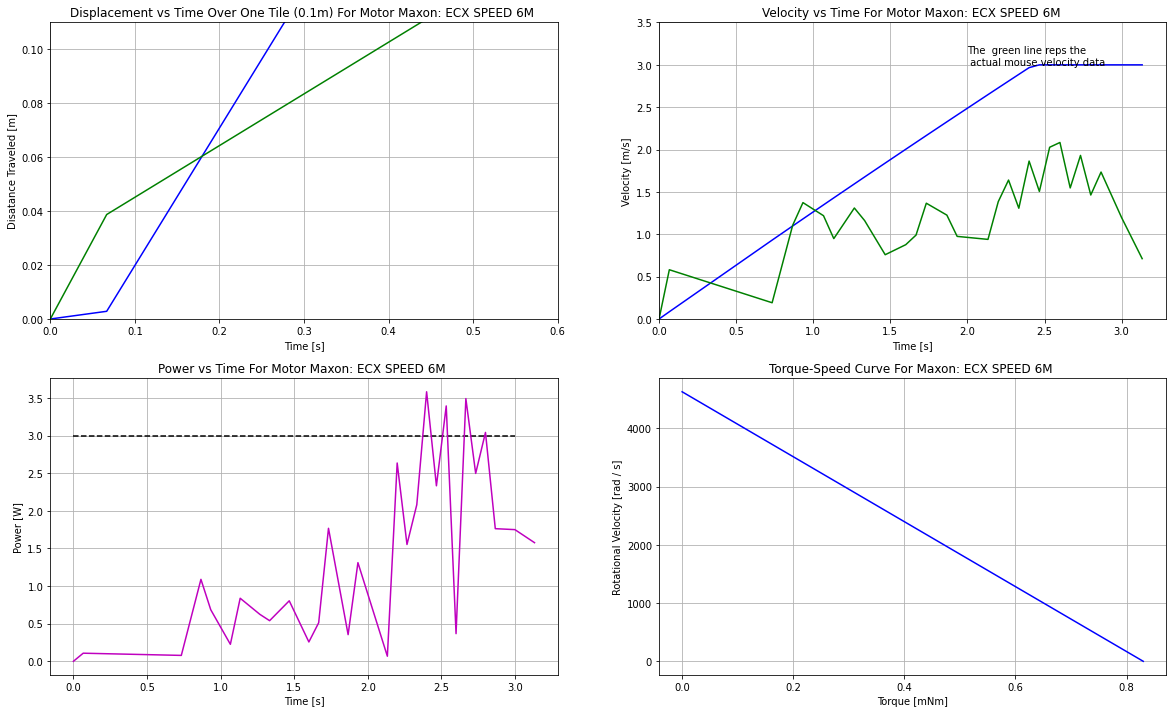

Average power is 1.35632320475217
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.6600660066006601 and resistance is 9.09 
 therefore I2R is 3.9603960396039604


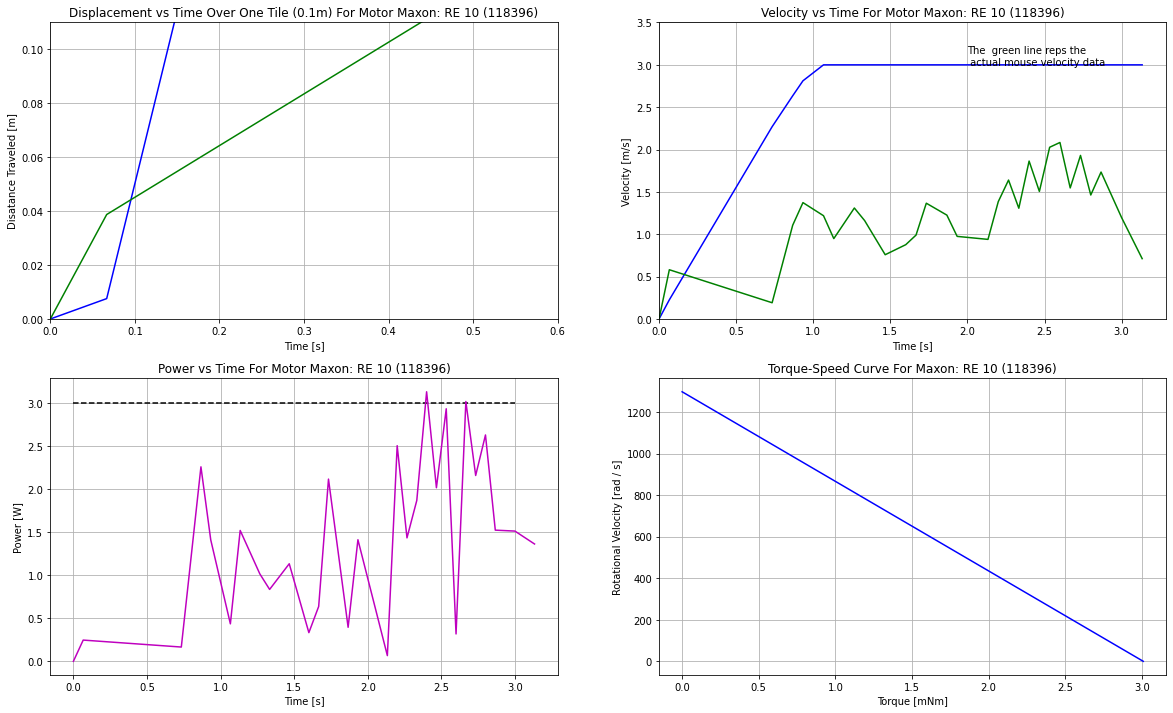

Average power is 1.392677634901785
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.4580152671755725 and resistance is 13.1 
 therefore I2R is 2.748091603053435


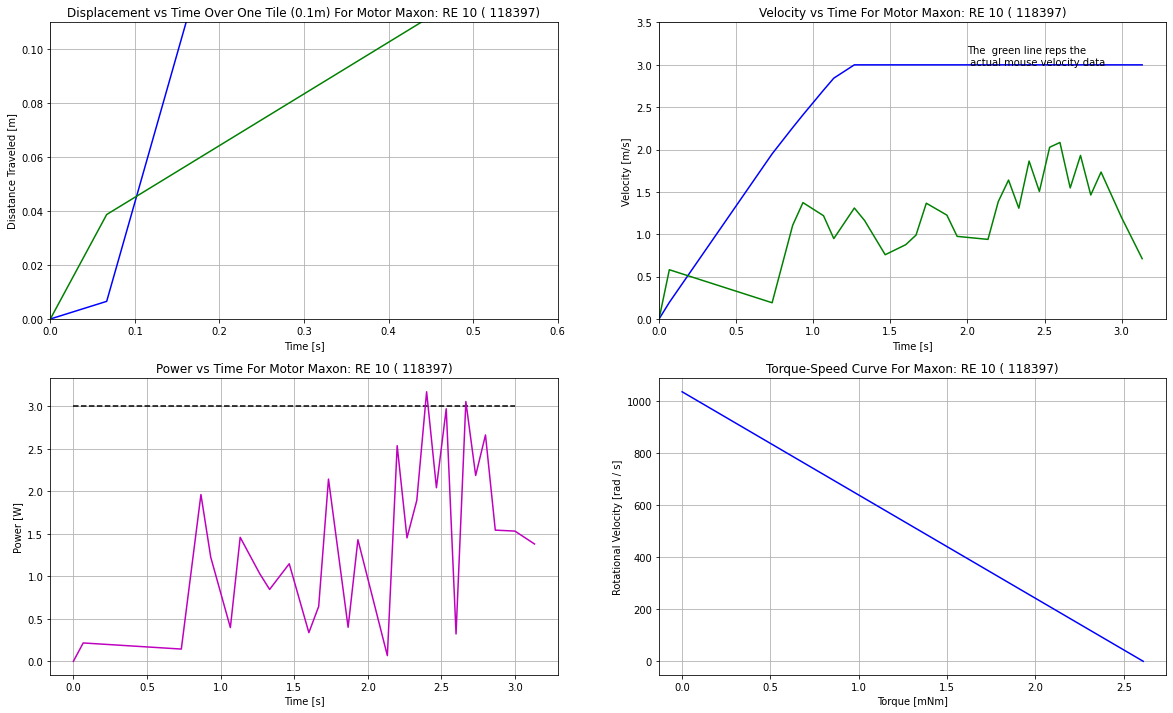

Average power is 1.3866788904380052
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.6600660066006601 and resistance is 9.09 
 therefore I2R is 3.9603960396039604


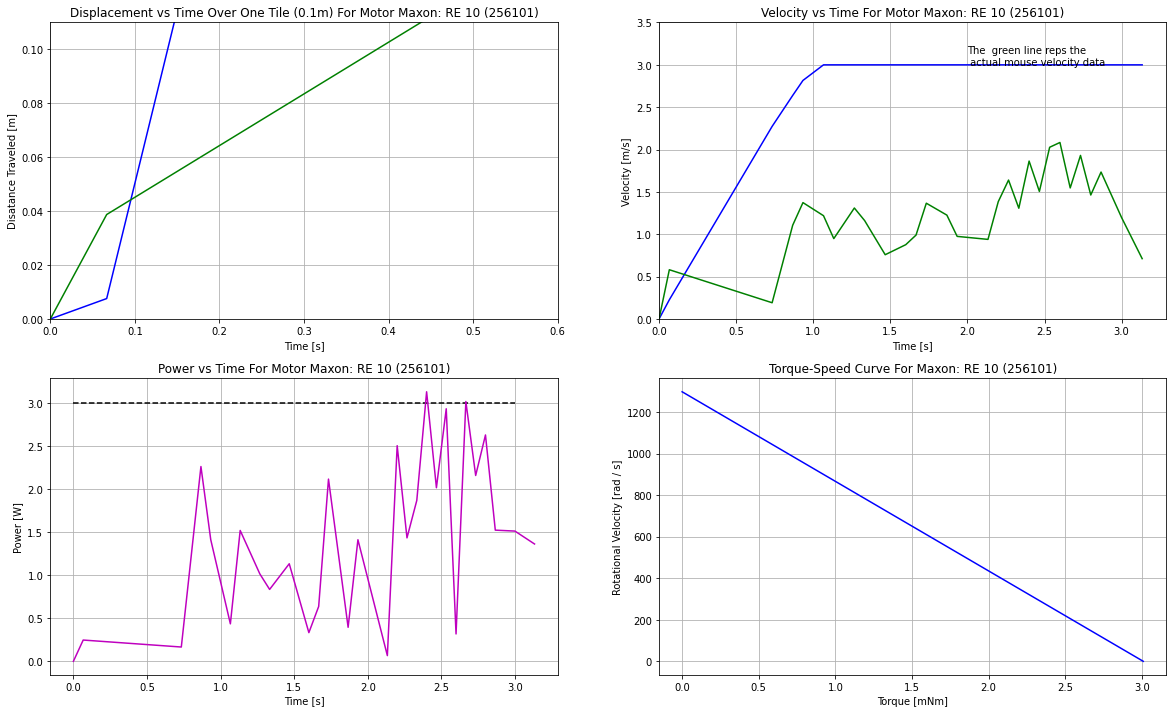

Average power is 1.3928985383446255
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.549618320610687 and resistance is 13.1 
 therefore I2R is 3.957251908396947


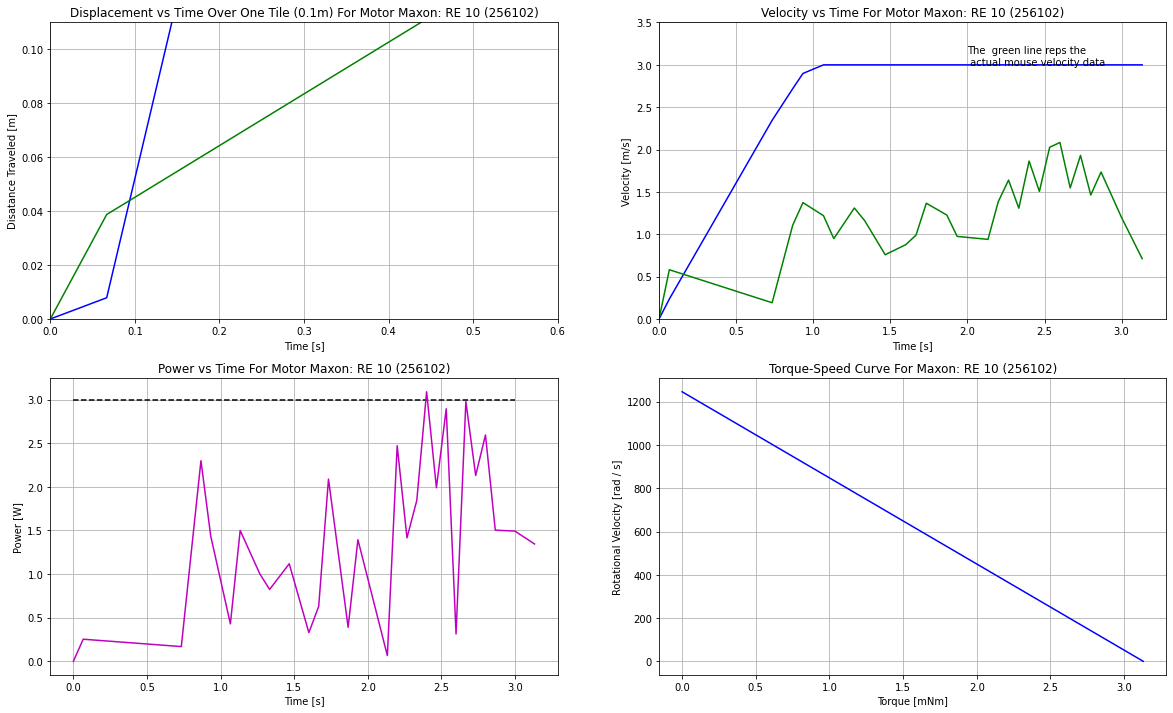

Average power is 1.3790319255743058
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.9375 and resistance is 6.4 
 therefore I2R is 5.625


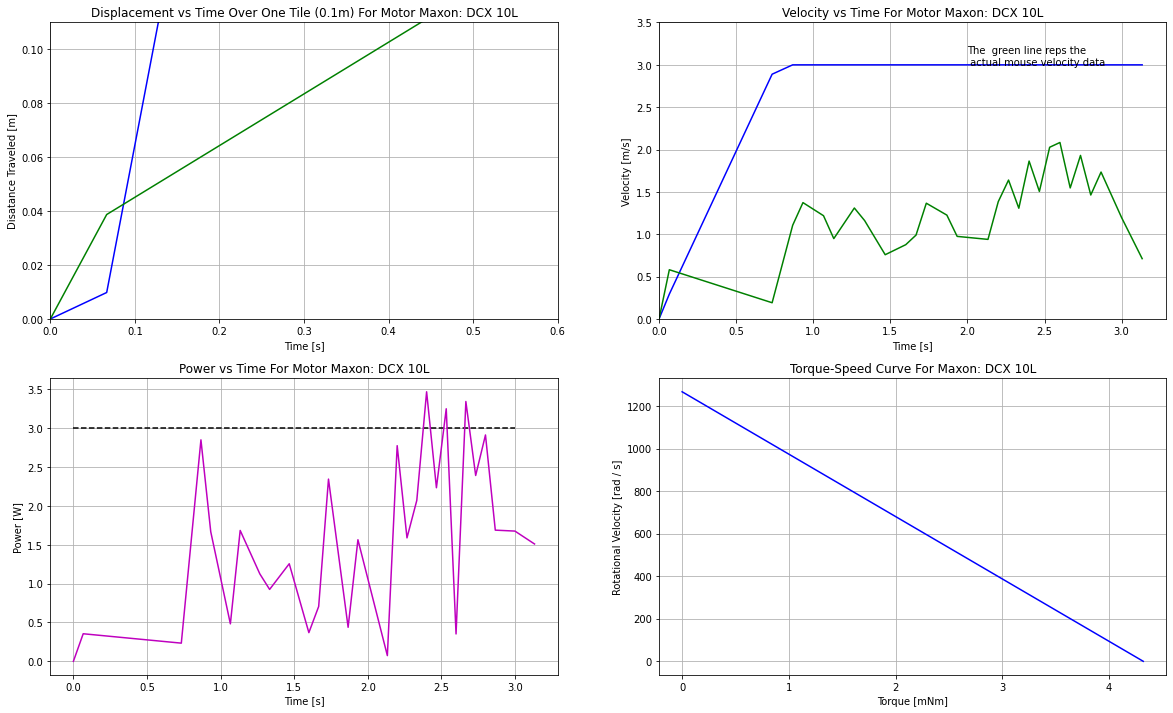

Average power is 1.5640207807518183
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.8141112618724559 and resistance is 7.37 
 therefore I2R is 4.8846675712347345


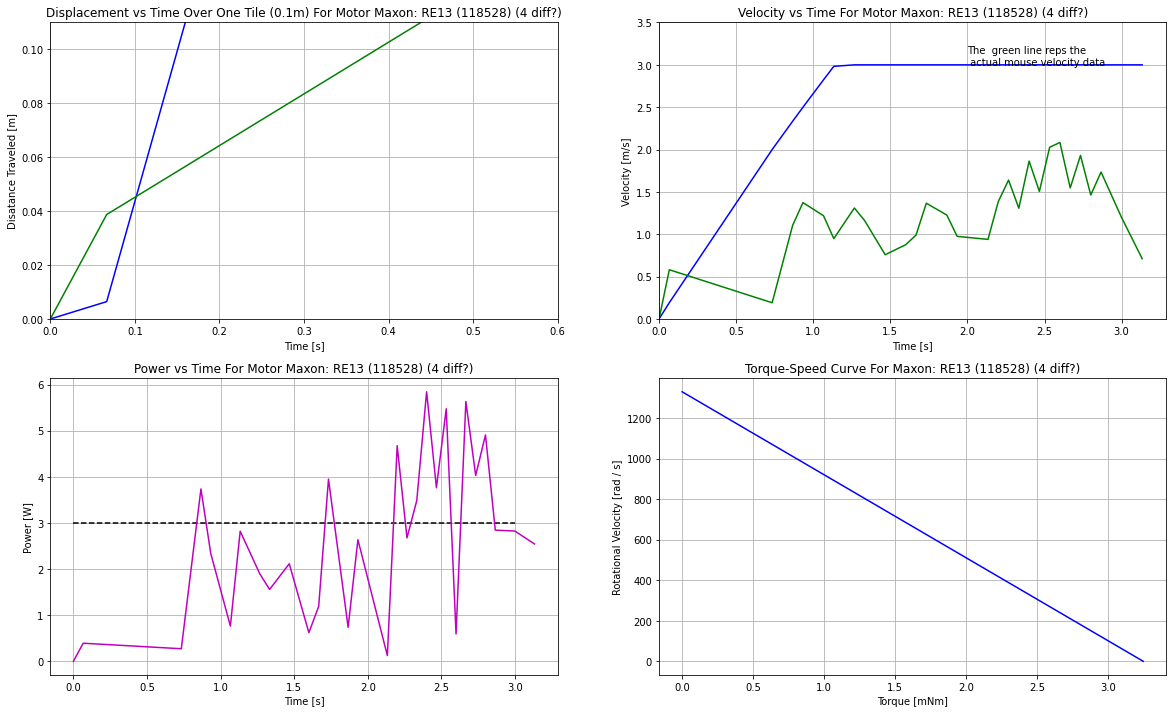

Average power is 2.5672341408434884
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.6371681415929203 and resistance is 11.3 
 therefore I2R is 4.587610619469027


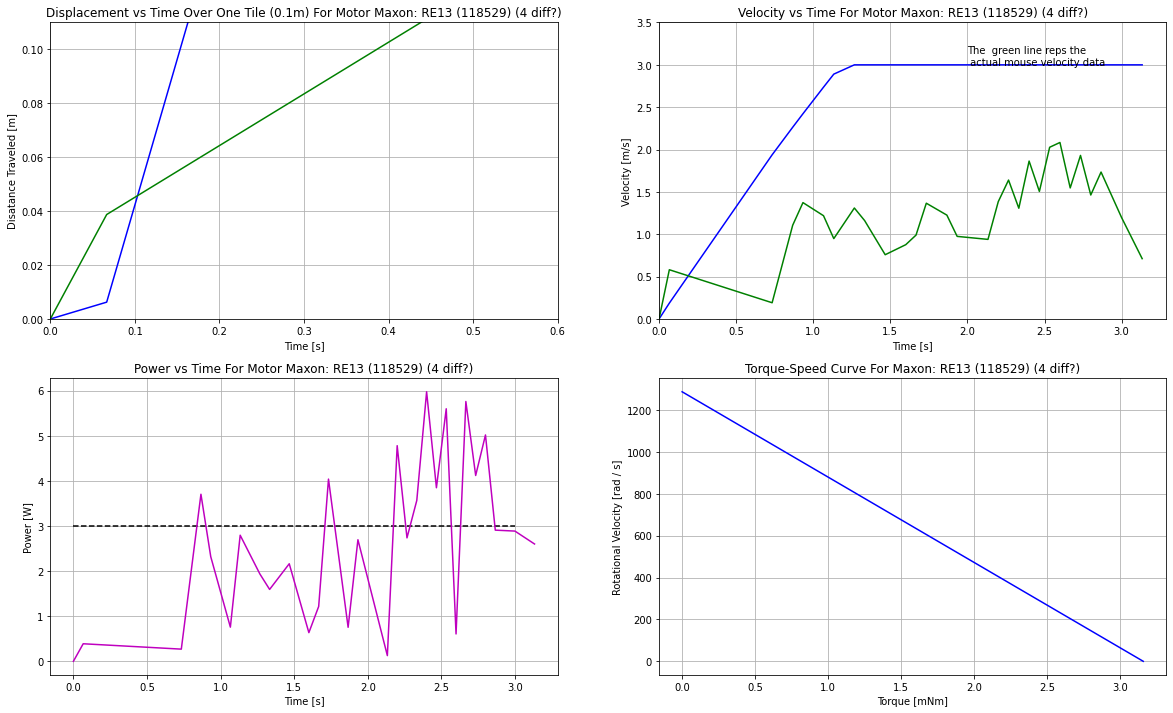

Average power is 2.6143756609211315
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.3821656050955414 and resistance is 15.7 
 therefore I2R is 2.292993630573249


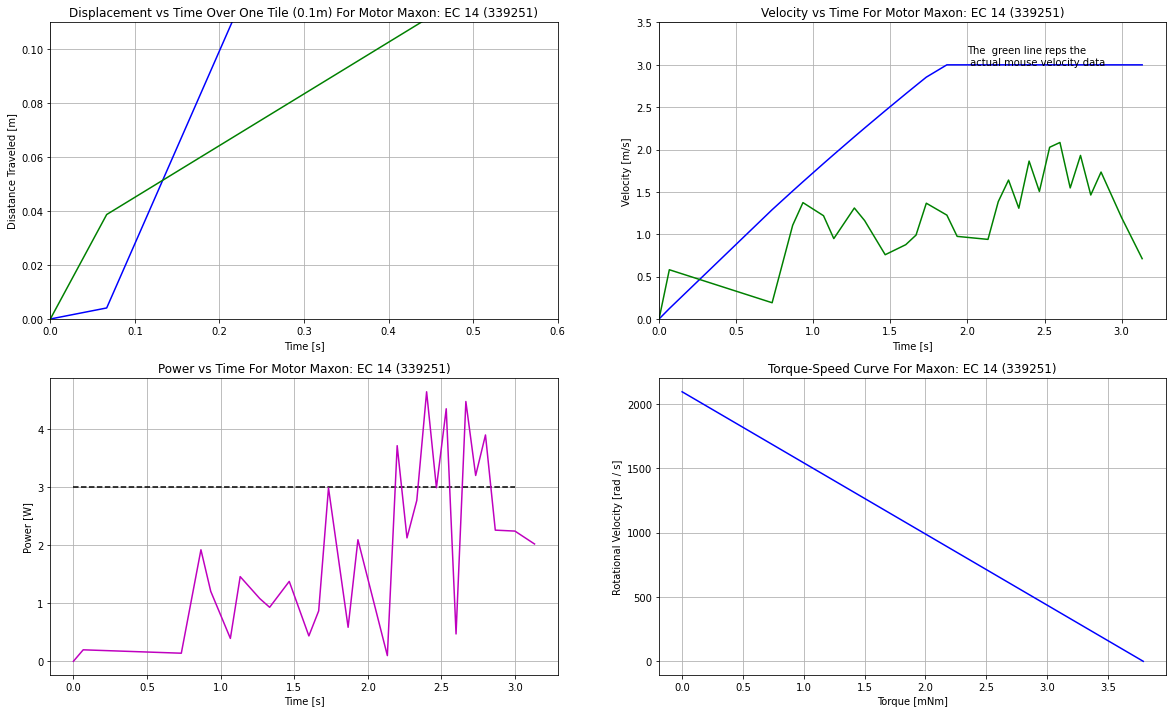

Average power is 1.8978600628959623
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.6423982869379015 and resistance is 9.34 
 therefore I2R is 3.8543897216274083


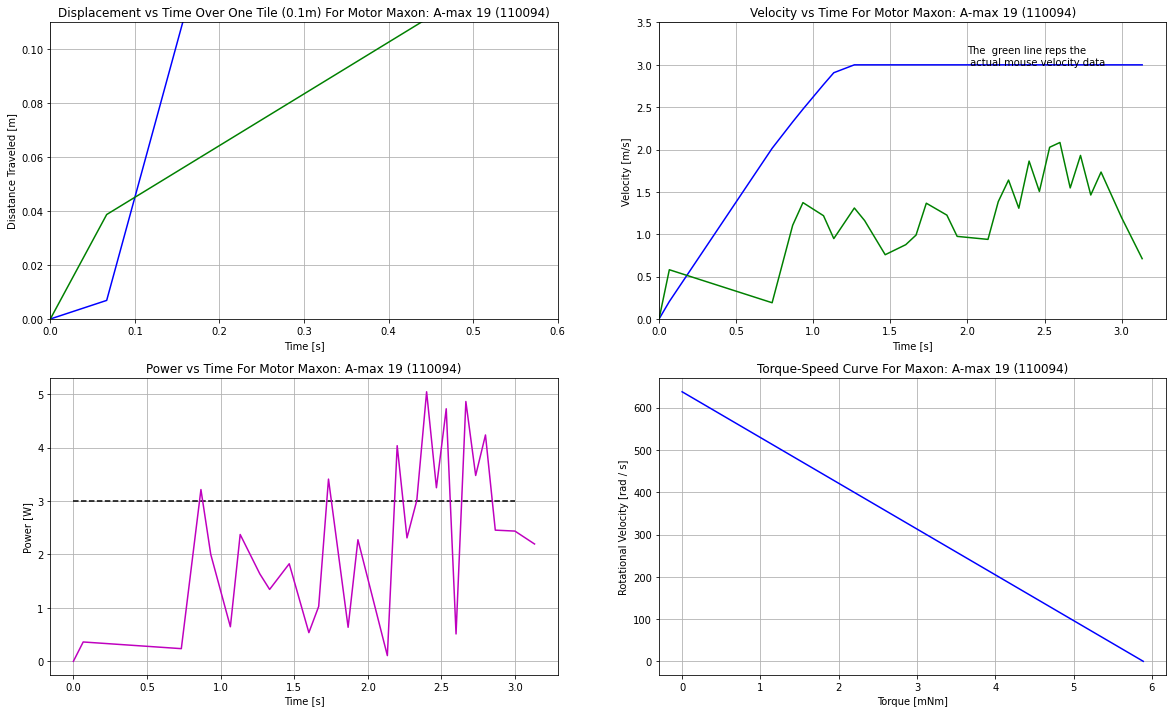

Average power is 2.2132344731735385
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 1.5W is 0.5217391304347826 and resistance is 13.8 
 therefore I2R is 3.756521739130435


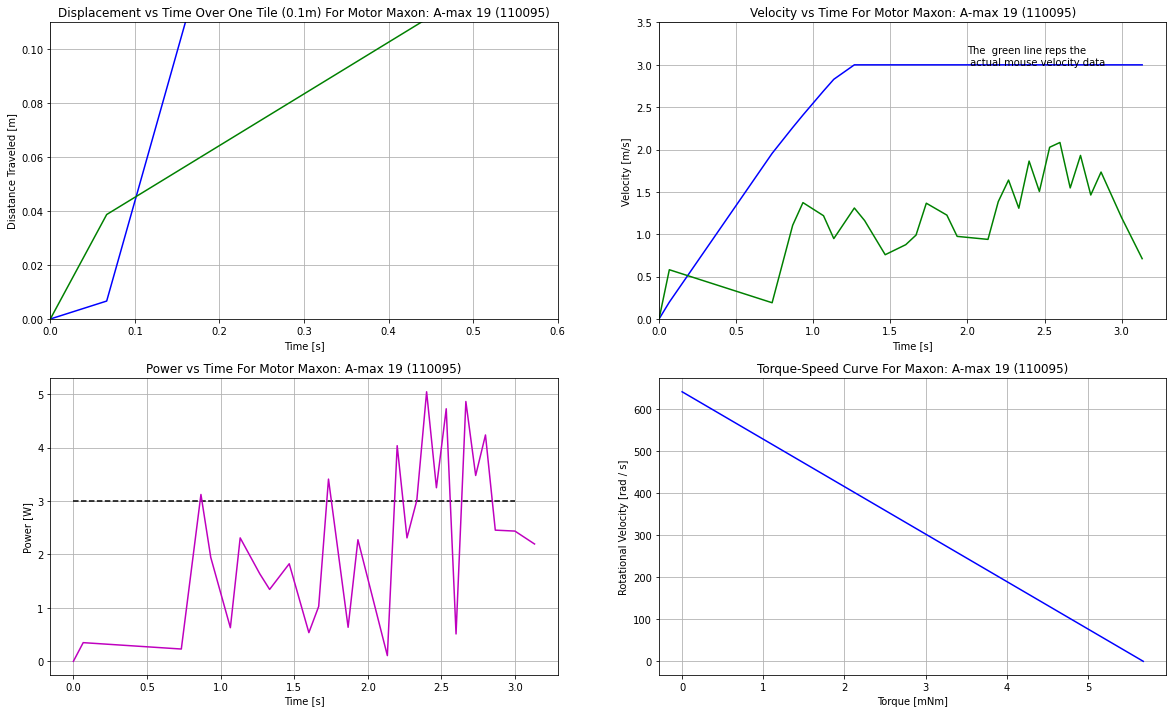

Average power is 2.2046570843664863
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [7]:
                                    # Plot 1.5W Motors INDIVIDUALLY#

G1 = 1

# These are approximate weights of some quick research I did into other parts we'll need
m_battery_g = 50
m_controller = 10
m_encoder = 5
m_other = 10
m_equip = m_battery_g + m_controller + m_encoder +  m_other

wheel_radii_15W = []
    
for i in range(len(all_motor_name_15W)): 
    motor_diam_15W = all_motor_diam_15W[i]
    kt_15W = all_motor_kt_15W[i]
    single_motor_m_15W = all_single_motor_weight_15W[i]
    input_V_15W = all_nominal_V_15W[i]
    motor_R_15W = all_motor_R_15W[i]
    motor_stall_t_15W = all_motor_stall_t_15W[i]
    motor_no_load_RPM_15W = all_motor_no_load_RPM_15W[i]
    motor_eff_15W = all_motor_eff_15W[i]
    
    m_total_15W = ((single_motor_m_15W*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
    no_load_w_15W = (2*math.pi*motor_no_load_RPM_15W) / 60
    
    motor_rad_15W = (motor_diam_15W / 2) 
    wheel_rad_15W = (motor_rad_15W + 5) / 1000
    wheel_radii_15W.append(wheel_rad_15W)
    
    I_15W = input_V_15W / motor_R_15W
    print(f"Current for 1.5W is {I_15W} and resistance is {motor_R_15W} \n therefore I2R is {I_15W*I_15W*motor_R_15W}")

    displacement1 = disp_simulation(m_total_15W, kt_15W, G1, input_V_15W, motor_R_15W, wheel_rad_15W, motor_eff_15W)
    
    vel1 = vel_simulation(m_total_15W, kt_15W, G1, input_V_15W, motor_R_15W, wheel_rad_15W, motor_eff_15W)
    
    accel1 = accel_simulation(m_total_15W, kt_15W, G1, input_V_15W, motor_R_15W, wheel_rad_15W, motor_eff_15W)

    power1 = input_power(accel, wheel_rad_15W, vel1, motor_eff_15W, m_total_15W, I_15W, motor_R_15W)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
############## Make the first graph a Dist vs Time graph for one tile (0.1m) ####################
    ax1.plot(time, displacement1, '-b')
    ax1.plot(seconds,distance_meter, '-g')
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel('Disatance Traveled [m]')
    ax1.grid(b=None, which='both', axis='both')
    ax1.set_ylim(bottom= 0, top = 0.11)
    ax1.set_xlim(left= 0, right = 0.6)
    ax1.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor {all_motor_name_15W[i]}')
    
############## Make the second graph a Vel vs Time graph ####################
    ax2.plot(time, vel1, '-b')
    ax2.plot(seconds,v2, "-g") # Plot the mouse data
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Velocity [m/s]')
    ax2.grid(b=None, which='both', axis='both')
    ax2.text(2.0, 3.0, f"The  green line reps the \n actual mouse velocity data")
    ax2.set_ylim(bottom= 0, top = 3.5)
    ax2.set_xlim(left= 0)
    ax2.set_title(f'Velocity vs Time For Motor {all_motor_name_15W[i]}')
    
############# Make the third graph a Power vs Time graph ####################
    ax3.plot(time, power1, '-m')
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel('Power [W]')
    ax3.hlines(3.0, 0, 3.0, color="black", linestyle="dashed")
    ax3.grid(b=None, which='both', axis='both')
    ax3.set_title(f'Power vs Time For Motor {all_motor_name_15W[i]}')

############# Make the fourth graph a torque-speed curve ####################
    ax4.plot([0, motor_stall_t_15W*G1], [no_load_w_15W / G1, 0], "-b")
    ax4.grid(b=None, which='both', axis='both')
    ax4.set_xlabel('Torque [mNm]')
    ax4.set_ylabel('Rotational Velocity [rad / s]')
    ax4.set_title(f'Torque-Speed Curve For {all_motor_name_15W[i]}')
    
    plt.show()

    p_len1 = len(power1)
    p_sum1 = sum(power1)
    p_ave1 = p_sum1 / p_len1
    
    print(f"Average power is {p_ave1}")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

Current for 2W is 1.7191977077363896 and resistance is 3.49 
 therefore I2R is 10.315186246418337


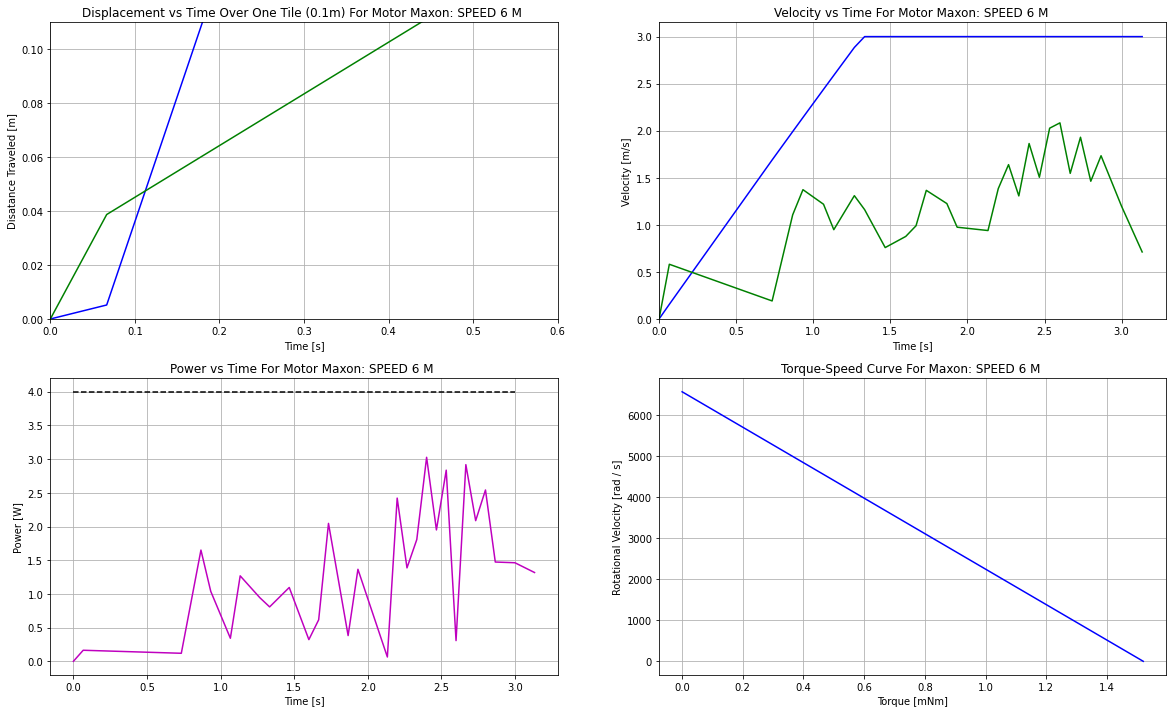

Average power is 1.3023800922405029
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2W is 1.9867549668874172 and resistance is 3.02 
 therefore I2R is 11.920529801324504


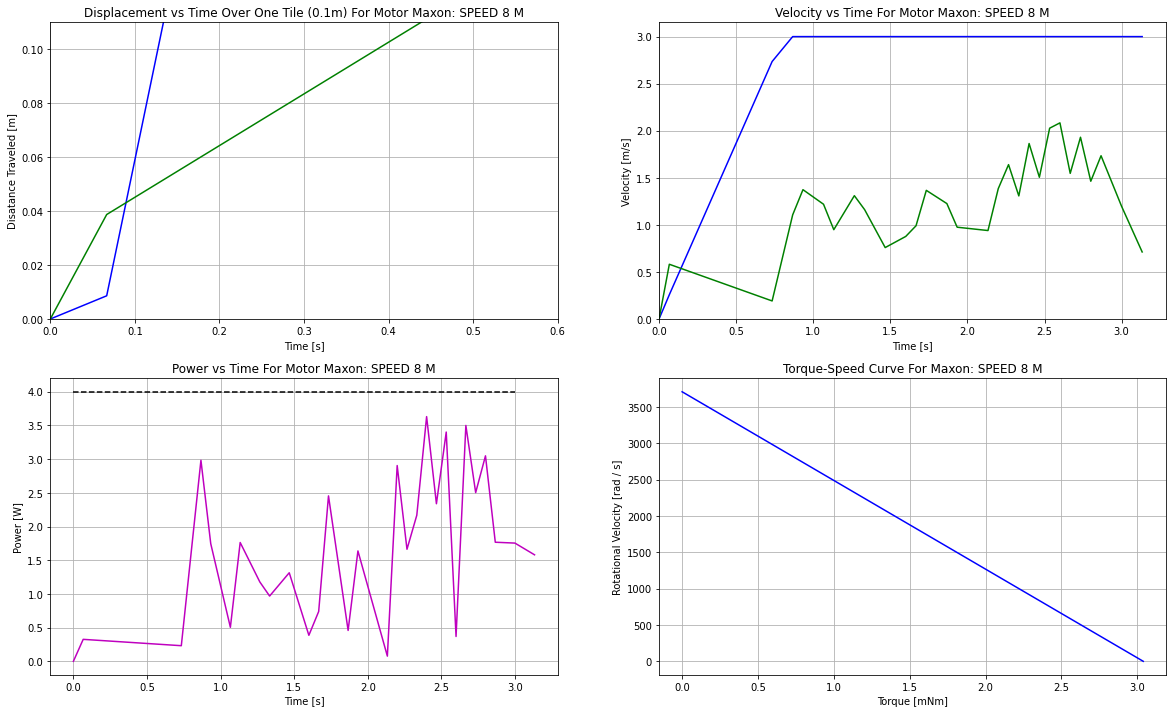

Average power is 1.6345659167044906
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2W is 0.6644518272425249 and resistance is 9.03 
 therefore I2R is 3.9867109634551494


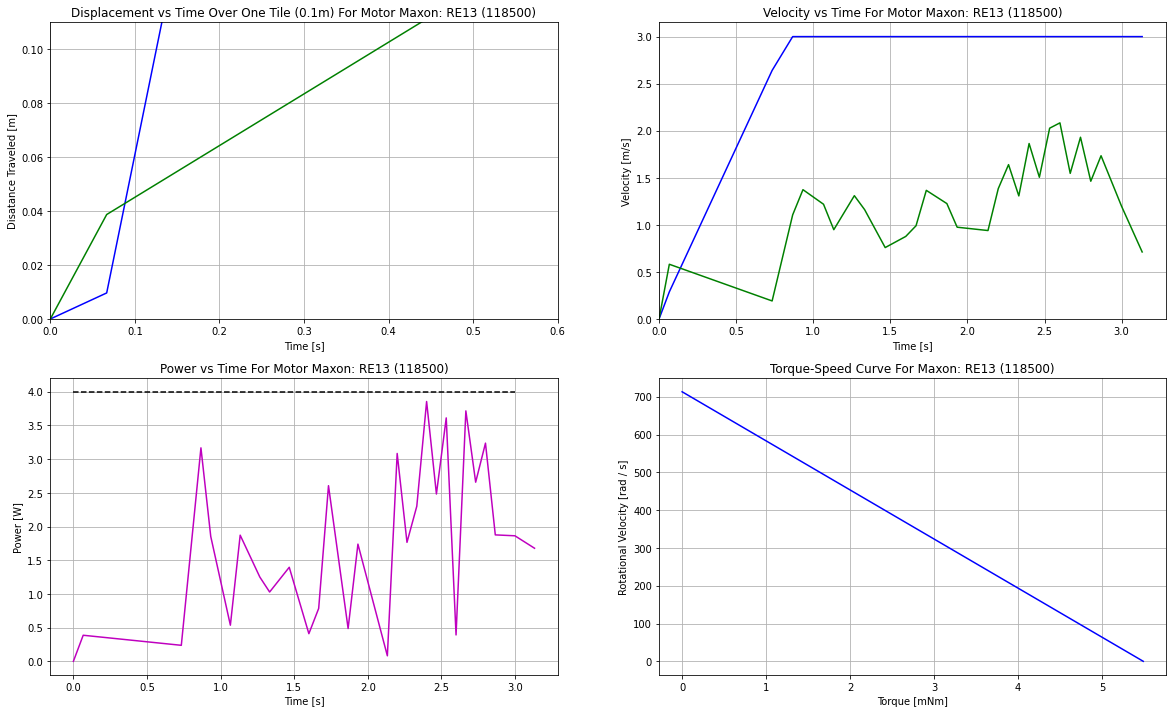

Average power is 1.7365379338027862
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2W is 0.5142857142857143 and resistance is 14.0 
 therefore I2R is 3.7028571428571437


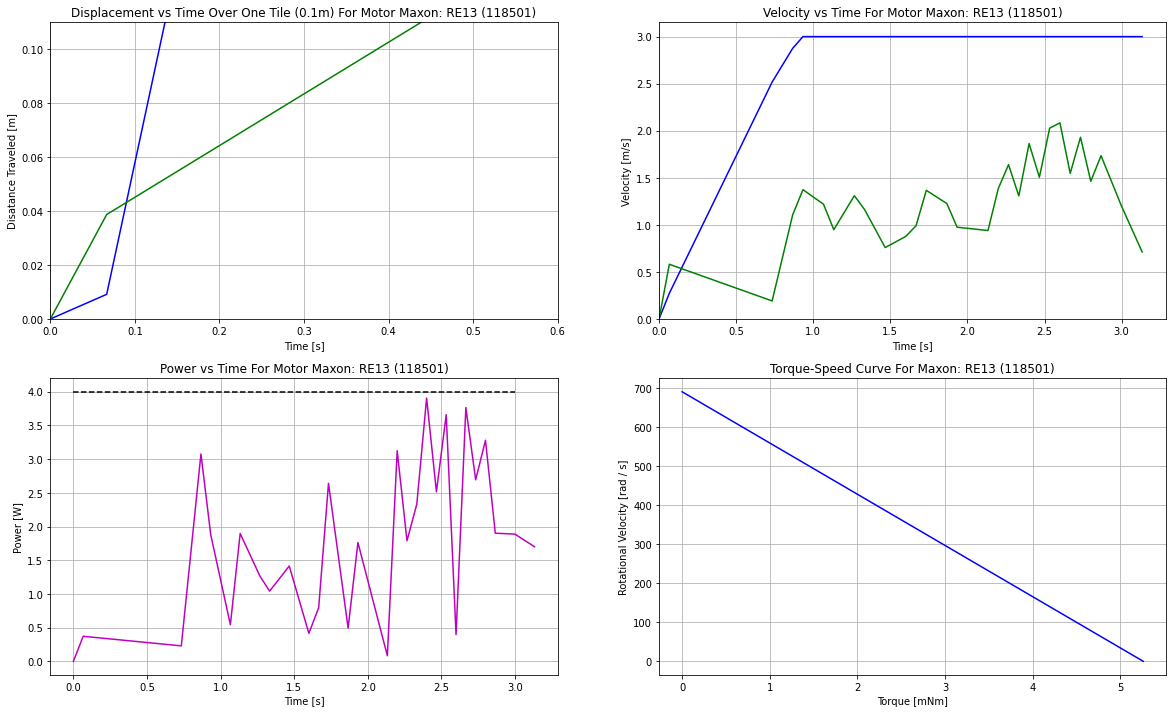

Average power is 1.7539904851664732
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2W is 0.8333333333333333 and resistance is 7.2 
 therefore I2R is 4.999999999999999


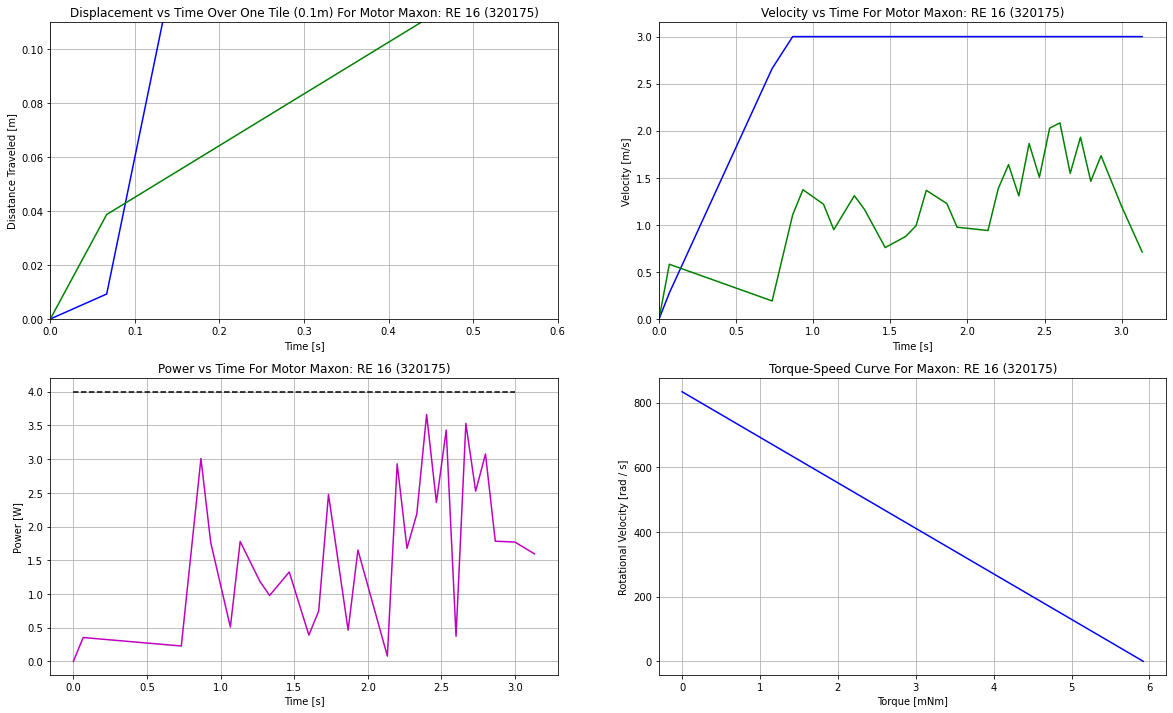

Average power is 1.6492659756515136
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2W is 0.7272727272727273 and resistance is 8.25 
 therefore I2R is 4.363636363636363


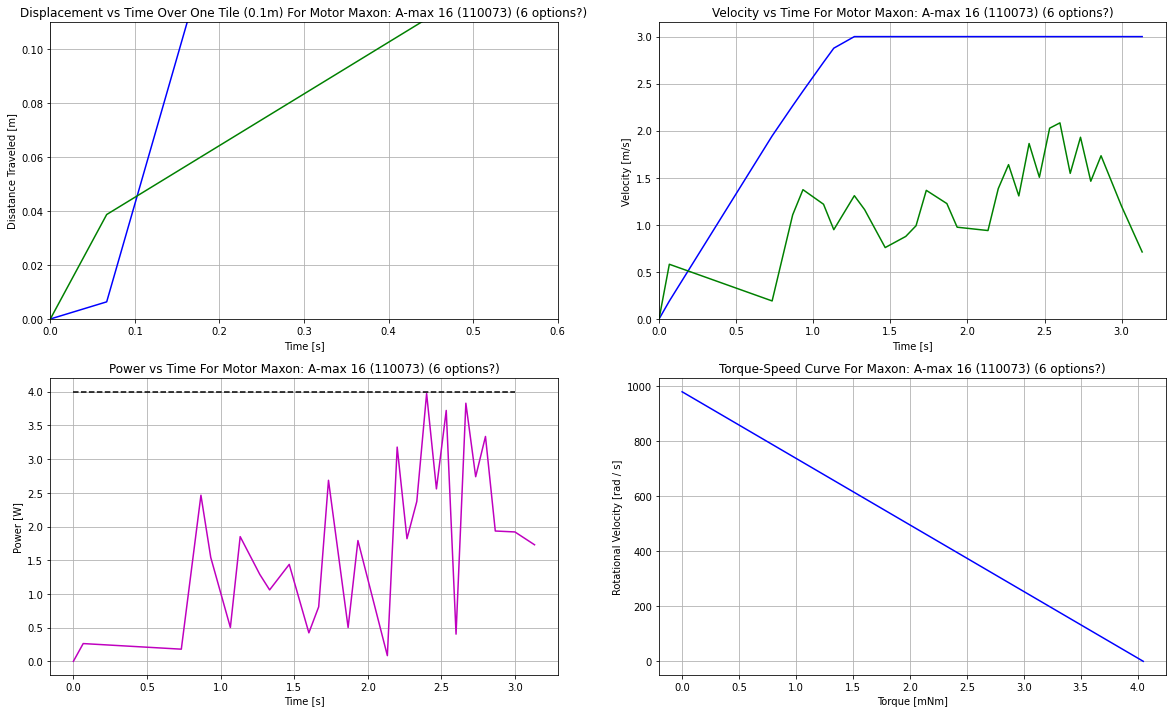

Average power is 1.7381248915259089
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2W is 1.4634146341463417 and resistance is 4.1 
 therefore I2R is 8.78048780487805


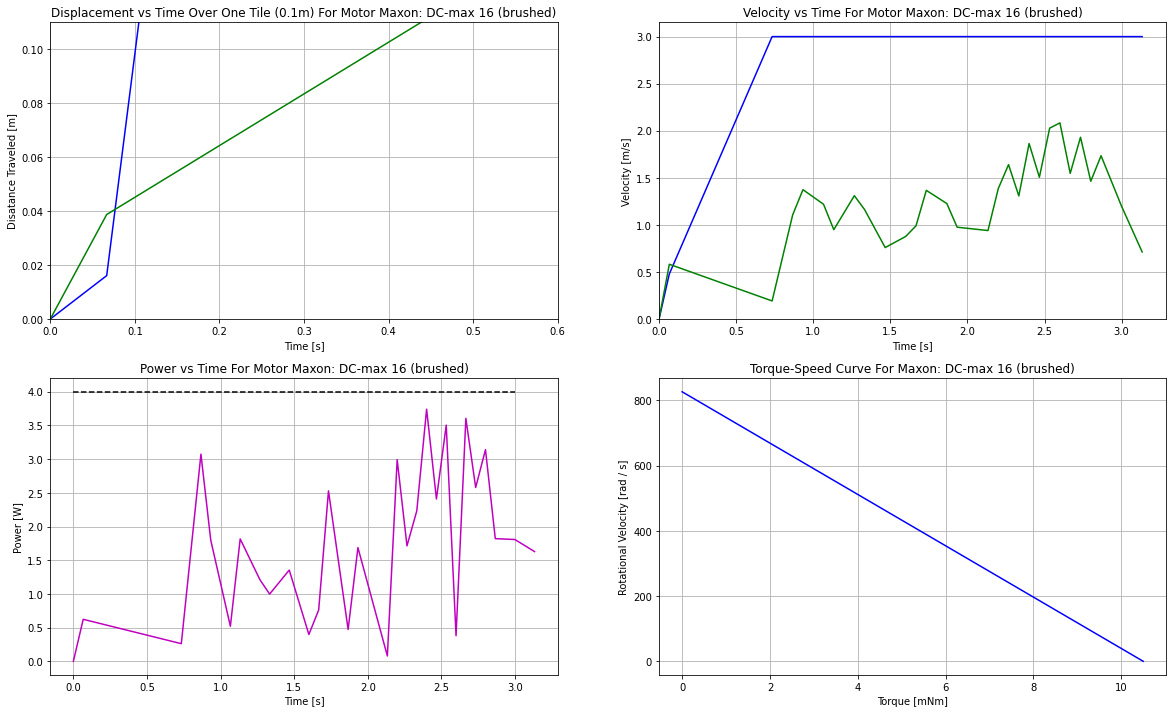

Average power is 1.6946842489049516
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [8]:
# Plot 2W Motors #
G2 = 1
wheel_radii_2W = []
    
for i in range(len(all_motor_name_2W)): 
    motor_diam_2W = all_motor_diam_2W[i]
    kt_2W = all_motor_kt_2W[i]
    single_motor_m_2W = all_single_motor_weight_2W[i]
    input_V_2W = all_nominal_V_2W[i]
    motor_R_2W = all_motor_R_2W[i]
    motor_stall_t_2W = all_motor_stall_t_2W[i]
    motor_no_load_RPM_2W = all_motor_no_load_RPM_2W[i]
    motor_eff_2W = all_motor_eff_2W[i]
    
    m_total_2W = ((single_motor_m_2W*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
    no_load_w_2W = (2*math.pi*motor_no_load_RPM_2W) / 60
    
    motor_rad_2W = (motor_diam_2W / 2) 
    wheel_rad_2W = (motor_rad_2W + 5) / 1000 ## Use a clearance of 5mm for the radius
    wheel_radii_2W.append(wheel_rad_2W)
    
    I_2W = input_V_2W / motor_R_2W
    
    displacement2 = disp_simulation(m_total_2W, kt_2W, G2, input_V_2W, motor_R_2W, wheel_rad_2W, motor_eff_2W)
    
    vel2 = vel_simulation(m_total_2W, kt_2W, G2, input_V_2W, motor_R_2W, wheel_rad_2W, motor_eff_2W)
    
    accel2 = accel_simulation(m_total_2W, kt_2W, G2, input_V_2W, motor_R_2W, wheel_rad_2W, motor_eff_2W)

    power2 = input_power(accel, wheel_rad_2W, vel2, motor_eff_2W, m_total_2W, I_2W, motor_R_2W)

    print(f"Current for 2W is {I_2W} and resistance is {motor_R_2W} \n therefore I2R is {I_2W*I_2W*motor_R_2W}")
    
    fig, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(20, 12))
    
############## Make the first graph a Dist vs Time graph ####################
    ax5.plot(seconds, displacement2, '-b')
    ax5.plot(seconds,distance_meter, '-g')
    ax5.set_xlabel('Time [s]')
    ax5.set_ylabel('Disatance Traveled [m]')
    ax5.grid(b=None, which='both', axis='both')
    ax5.set_ylim(bottom= 0, top = 0.11)
    ax5.set_xlim(left= 0, right = 0.6)
    ax5.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor {all_motor_name_2W[i]}')

############## Make the second graph a Vel vs Time graph ####################
    ax6.plot(seconds, vel2, '-b')
    ax6.plot(seconds,v2, "-g") # Plot the mouse data
    ax6.set_xlabel('Time [s]')
    ax6.set_ylabel('Velocity [m/s]')
    ax6.grid(b=None, which='both', axis='both')
    ax6.set_ylim(bottom= 0)
    ax6.set_xlim(left= 0)
    ax6.set_title(f'Velocity vs Time For Motor {all_motor_name_2W[i]}')
    
############## Make the third graph a Power vs Time graph #################### 
    ax7.plot(seconds, power2, '-m')
    ax7.set_xlabel('Time [s]')
    ax7.set_ylabel('Power [W]')
    ax7.hlines(4.0, 0, 3.0, color="black", linestyle="dashed")
    ax7.grid(b=None, which='both', axis='both')
    ax7.set_title(f'Power vs Time For Motor {all_motor_name_2W[i]}')
    
############## Make the fourth graph a torque-speed curve ####################
    ax8.plot([0, motor_stall_t_2W*G2], [no_load_w_2W / G2, 0], "-b")
    ax8.grid(b=None, which='both', axis='both')
    ax8.set_xlabel('Torque [mNm]')
    ax8.set_ylabel('Rotational Velocity [rad / s]')
    ax8.set_title(f'Torque-Speed Curve For {all_motor_name_2W[i]}')
    
    plt.show()
    
    p_len2 = len(power2)
    p_sum2 = sum(power2)
    p_ave2 = p_sum2 / p_len2
    
    print(f"Average power is {p_ave2}")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

In [9]:
## Plot all the 1.5 and 2W motors on one graph (1.5W gets its own graph as does 2W)
## Oof, kinda hard to tell apart

# fig, (ax21, ax22) = plt.subplots(2, 1, figsize=(20, 20))
# for j in range(1, 5):
#     ax21.plot(time, power_15W_compare[j])
# for k in range(len(all_motor_name_2W)):
#     ax22.plot(time, power_2W_compare[k])

Current for 2.5W is 1.6304347826086956 and resistance is 3.68 
 therefore I2R is 9.782608695652174


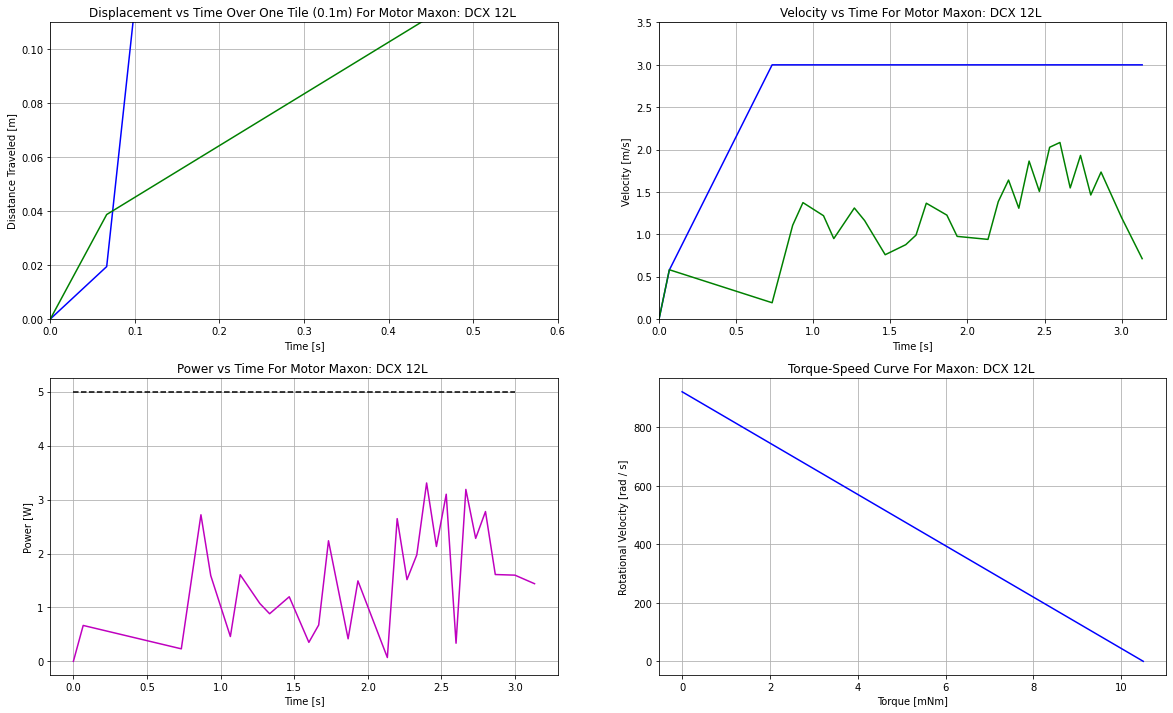

Average power is 1.5025460972880063
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2.5W is 1.7142857142857142 and resistance is 3.5 
 therefore I2R is 10.285714285714285


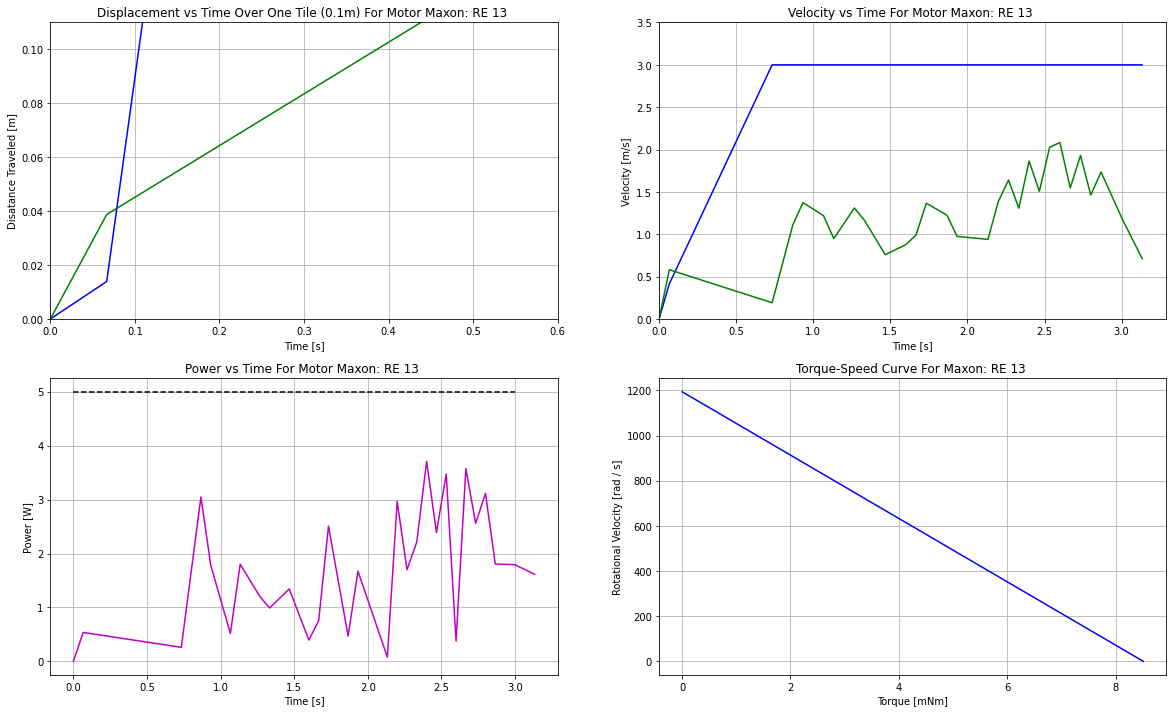

Average power is 1.6773139224422968
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2.5W is 1.4845360824742269 and resistance is 4.85 
 therefore I2R is 10.688659793814432


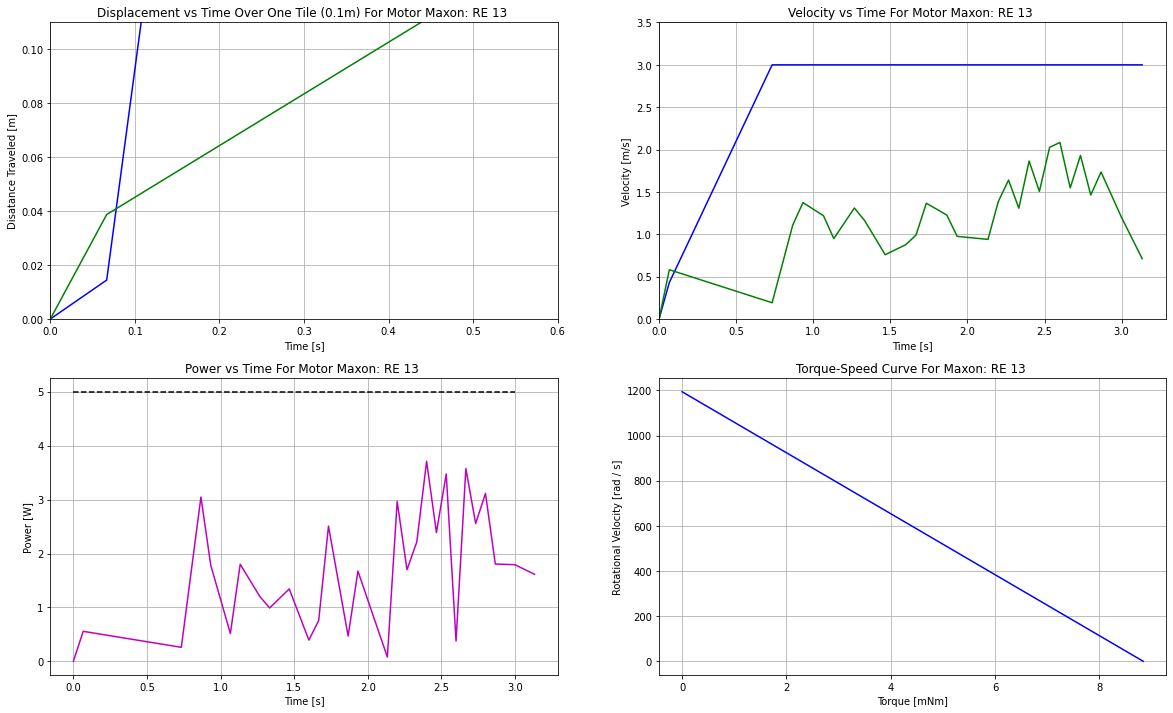

Average power is 1.678020350063847
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2.5W is 1.4778325123152711 and resistance is 4.06 
 therefore I2R is 8.866995073891628


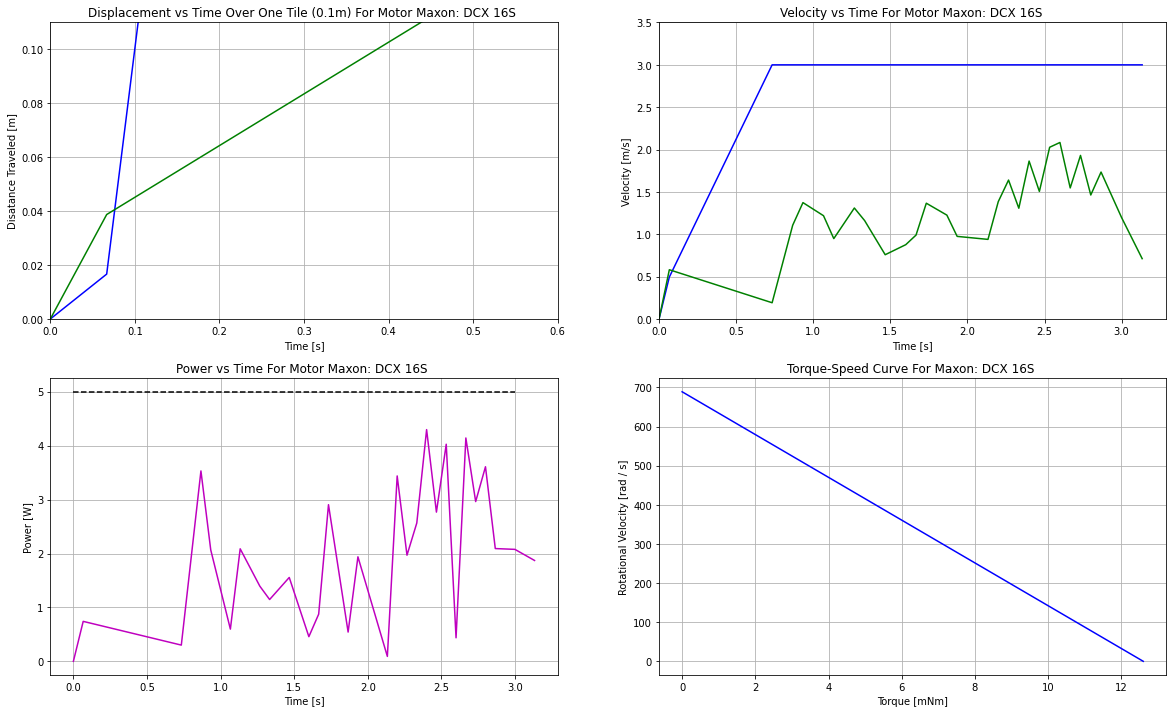

Average power is 1.9478279158553122
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2.5W is 2.7027027027027026 and resistance is 2.22 
 therefore I2R is 16.216216216216218


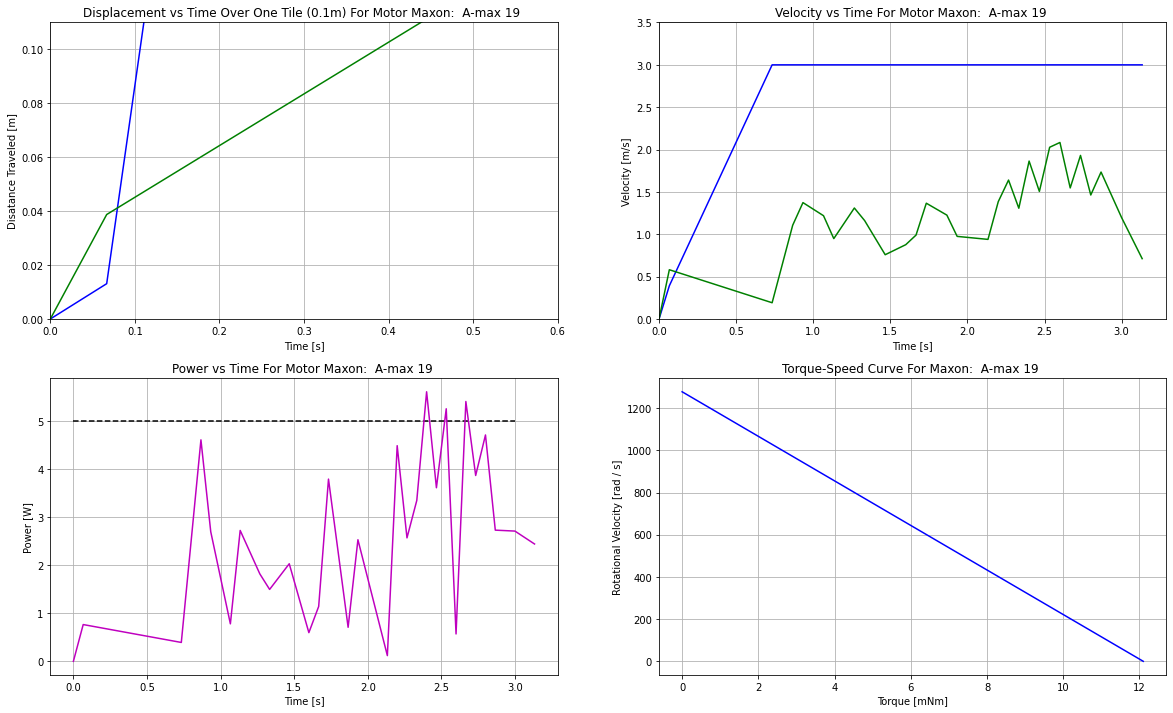

Average power is 2.5331764077354637
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Current for 2.5W is 1.2244897959183674 and resistance is 5.88 
 therefore I2R is 8.816326530612244


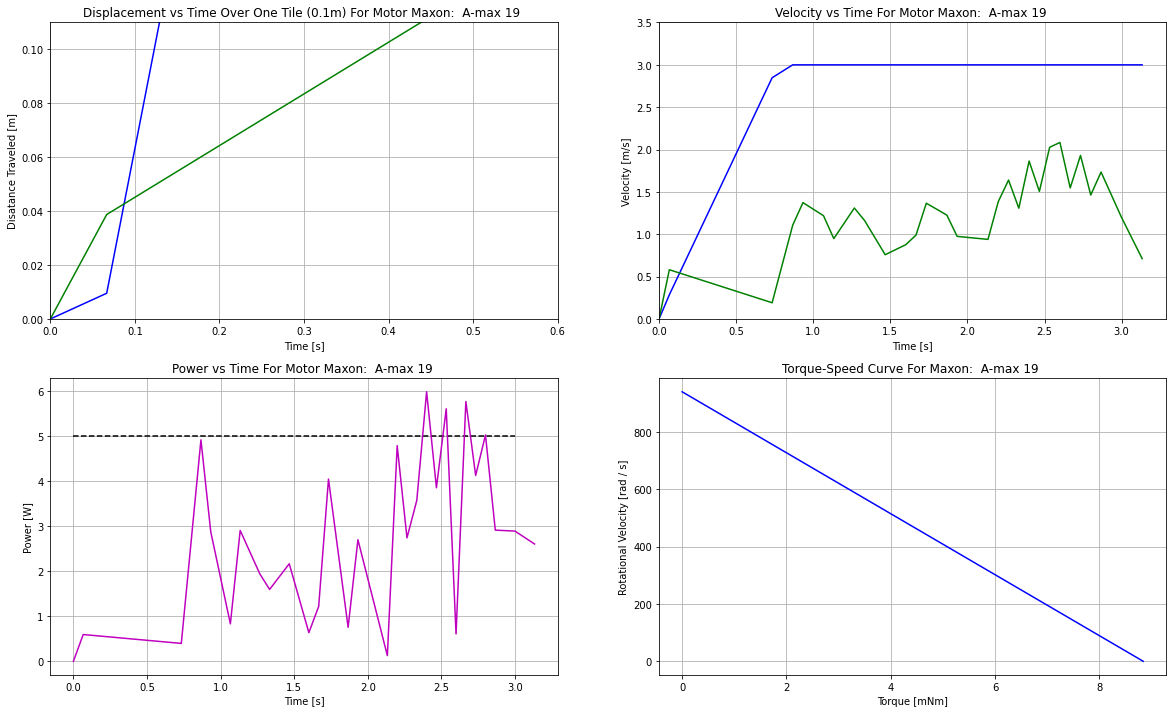

Average power is 2.6965460628247855
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________



In [10]:
# Plot 2.5W Motors #
G3 = 1

wheel_radii_25W = []
    
for i in range(len(all_motor_name_25W)): 
    motor_diam_25W = all_motor_diam_25W[i]
    kt_25W = all_motor_kt_25W[i]
    single_motor_m_25W = all_single_motor_weight_25W[i]
    input_V_25W = all_nominal_V_25W[i]
    motor_R_25W = all_motor_R_25W[i]
    motor_stall_t_25W = all_motor_stall_t_25W[i]
    motor_no_load_RPM_25W = all_motor_no_load_RPM_25W[i]
    motor_eff_25W = all_motor_eff_25W[i]
    
    m_total_25W = ((single_motor_m_25W*2) + m_battery_g + m_controller + m_encoder +  m_other) / 1000
    
    no_load_w_25W = (2*math.pi*motor_no_load_RPM_25W) / 60
    
    motor_rad_25W = (motor_diam_25W / 2) 
    wheel_rad_25W = (motor_rad_25W + 5) / 1000 ## Use a clearance of 5mm for the radius
    wheel_radii_25W.append(wheel_rad_25W)
    
    I_25W = input_V_25W / motor_R_25W
    
    displacement3 = disp_simulation(m_total_25W, kt_25W, G3, input_V_25W, motor_R_25W, wheel_rad_25W, motor_eff_25W)
    
    vel3 = vel_simulation(m_total_25W, kt_25W, G3, input_V_25W, motor_R_25W, wheel_rad_25W, motor_eff_25W)
    
    accel3 = accel_simulation(m_total_25W, kt_25W, G3, input_V_25W, motor_R_25W, wheel_rad_25W, motor_eff_25W)

    power3 = input_power(accel, wheel_rad_25W, vel3, motor_eff_25W, m_total_25W, I_25W, motor_R_25W)
    
    print(f"Current for 2.5W is {I_25W} and resistance is {motor_R_25W} \n therefore I2R is {I_25W*I_25W*motor_R_25W}")
    
    fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 12))
    
############## Make the first graph a Dist vs Time graph ####################
    ax11.plot(time, displacement3, '-b')
    ax11.plot(seconds,distance_meter, '-g')
    ax11.set_xlabel('Time [s]')
    ax11.set_ylabel('Disatance Traveled [m]')
    ax11.grid(b=None, which='both', axis='both')
    ax11.set_ylim(bottom= 0, top = 0.11)
    ax11.set_xlim(left= 0, right = 0.6)
    ax11.set_title(f'Displacement vs Time Over One Tile (0.1m) For Motor {all_motor_name_25W[i]}')

############## Make the second graph a Vel vs Time graph ####################
    ax12.plot(time, vel3, '-b')
    ax12.plot(seconds,v2, "-g") # Plot the mouse data
    ax12.set_xlabel('Time [s]')
    ax12.set_ylabel('Velocity [m/s]')
    ax12.grid(b=None, which='both', axis='both')
#     ax12.text(2.0, 3.0, f"The  green line reps the \n actual mouse velocity data")
    ax12.set_ylim(bottom= 0, top = 3.5)
    ax12.set_xlim(left= 0)
    ax12.set_title(f'Velocity vs Time For Motor {all_motor_name_25W[i]}')
    
############## Make the third graph a Power vs Time graph ####################
    ax13.plot(seconds, power3, '-m')
    ax13.set_xlabel('Time [s]')
    ax13.set_ylabel('Power [W]')
    ax13.hlines(5.0, 0, 3.0, color="black", linestyle="dashed")
    ax13.grid(b=None, which='both', axis='both')
    ax13.set_title(f'Power vs Time For Motor {all_motor_name_25W[i]}')
    
############## Make the fourth graph a torque-speed curve ####################
    ax14.plot([0, motor_stall_t_25W*G3], [no_load_w_25W / G3, 0], "-b")
    ax14.set_xlabel('Torque [mNm]')
    ax14.set_ylabel('Rotational Velocity [rad / s]')
    ax14.grid(b=None, which='both', axis='both')
    ax14.set_title(f'Torque-Speed Curve For {all_motor_name_25W[i]}')
    
    plt.show()
    
    p_len3 = len(power3)
    p_sum3 = sum(power3)
    p_ave3 = p_sum3 / p_len3
    
    print(f"Average power is {p_ave3}")
    print("_________________________________________________________________________________________________________________")
    print("_________________________________________________________________________________________________________________\n")

Given the gear ratios G = 1:, 3:1 & 5:1, we can see that for some of the "higher" gear reductions, our maximum linear velocity plateaus. This is fine so long as the velocity plateaus above the mouse's max velcocity. If that is not the case, then we need to choose a smaller gear reduction. (**DOES THIS MAKE SENSE?**)

Now that we are starting to make sense of the linear velocity data, that means we can narrow down the angular velocities needed. But now we need to see if these motor's reach our torque requirements. Should I find an average motor acceleration based on my acceleration graphs above and use that $F = ma$, $\tau = Fr$ and therefore $\tau = mar$ ?

## Now that we have all the individual motor specs, lets make some graphs to compare different motors and gear ratios


<!-- ## I know we dont have a constant acceleration, but lets express the relationship between acceleration and torque


Given the formulas...

$F = ma$

$\tau = Fr$

We can say that...

$\tau = mar$

We can graph the simple relationship between torque and  acceleration.  -->

<!-- ## Battery Calculations 

The battery I've been modeling with is rated at a capactiy of 950mAh, V = 7.4 and C = 25 constant, 50 burst. 

https://hobbyking.com/en_us/turnigy-nano-tech-950mah-2s-25-50c-lipo-pack.html?queryID=1eaac594597e79e054b2ad91f52d2667&objectID=47397&indexName=hbk_live_magento_en_us_products

At shortest time and maximum current draw:

$60min / 25C = 2.4 min$

$I = 0.95(25) = 23.75 A$

From our previous discussions, we said that given a 45min - 1hour experiment, we can predict that a battery should last on average at least 15 minutes. So for 15 minutes...

$60min / 15min = 4C$

For 4C, I can draw up to... 

$I = .95(4) = 3.8A$ -->

# Given the mouse time interval, use the acceleration calualted at each time step to determine the torque needed at that time step.

# Given the graphs above, use the angular velocity at each time step and determine the power at each time step

We'll address the acceleration stuff later, for now lets look at how we determine the power at each time step. 

From our previous calculations, we know that we have the input electrical power $P_e = IV$ and our output mechancial power $P_{mech} = \tau \omega$. However, not all of the input power is converted to electrical power since motors are not 100% efficient. The effeciency of a motor is determined by...

$\eta = \frac{P_{mech}}{P_e} =  \frac{\tau_{out} \omega}{IV}$

In other words

$P_{input} = P_e = \frac{P_{mech}}{\eta} + {I}^2 R = \frac{\tau_{out} \omega}{\eta} + {I}^2 R $